In [2]:
# laod the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.utils.data as data
from sklearn.linear_model import LinearRegression

In [3]:
# load data
url = 'https://github.com/facebook/prophet/blob/main/examples/example_retail_sales.csv?raw=true'
dt = pd.read_csv(url)
# format data
dt['ds'] = pd.to_datetime(dt['ds']) # convert to datetime
dt.columns = ['date', 'sales'] # rename columns
dt.head()

,date,sales
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [4]:
# generate the time series data
month = dt['date'].dt.month.to_numpy()
timeseries = dt['sales'].values.astype('float64')

# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [23]:
# split the month data
train_month = month[:train_size]
test_month = month[train_size:]
train_reshaped = train.reshape(-1, 1)

# add the feature to the train set
month_sin_train = np.sin(2 * np.pi * train_month / 12)
month_cosine_train = np.cos(2 * np.pi * train_month / 12)
train_with_month = np.hstack((train_reshaped, month_sin_train.reshape(-1, 1), month_cosine_train.reshape(-1, 1)))

# add the feature to the test set
test_reshaped = test.reshape(-1, 1)
month_sin_test = np.sin(2 * np.pi * test_month / 12)
month_cosine_test = np.cos(2 * np.pi * test_month / 12)
test_with_month = np.hstack((test_reshaped, month_sin_test.reshape(-1, 1), month_cosine_test.reshape(-1, 1)))

Text(0, 0.5, 'Month')

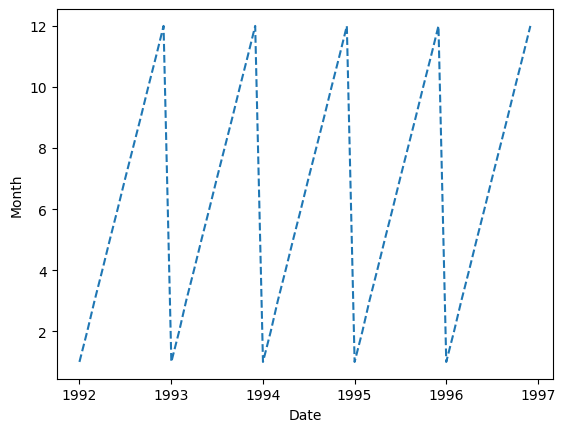

In [62]:
plt.plot(dt['date'][0:60], dt['date'].dt.month[0:60], label='Month vs Date', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Month')

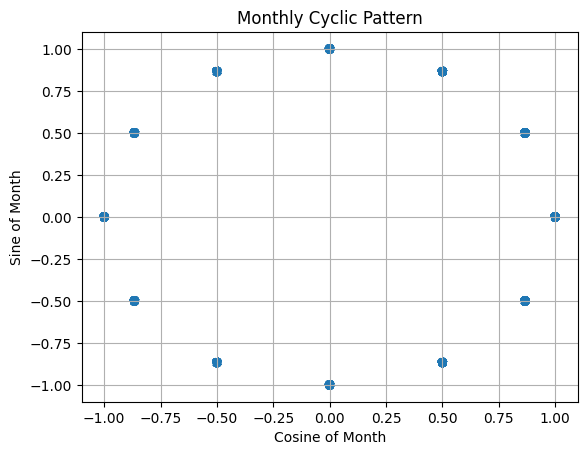

In [60]:
# Extract the month from the datetime column
months = dt['date'].dt.month
plt.scatter(np.cos(2 * np.pi * months / 12), np.sin(2 * np.pi * months / 12), linestyle = '--')
plt.xlabel('Cosine of Month')
plt.ylabel('Sine of Month')
plt.title('Monthly Cyclic Pattern')
plt.grid(True)

In [28]:
# detrend the data
# using a linear regression model

X_trend = np.arange(len(timeseries)).reshape(-1, 1)
trend_model = LinearRegression().fit(X_trend[:train_size], train_with_month[:, 0])
trend_train = trend_model.predict(X_trend[:train_size])
trend_test = trend_model.predict(X_trend[train_size:])


detrended_train = train_with_month[:,0] - trend_train
detrended_test = test_with_month[:,0] - trend_test

# replace the original data with the detrended data
train_with_month[:, 0] = detrended_train
test_with_month[:, 0] = detrended_test

In [29]:
# Normalize between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_with_month)
test_scaled = scaler.transform(test_with_month)

In [30]:
# Create a dataset for the LSTM model
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [31]:
lookback = 24
# Update dataset function to use scaled data
X_train, y_train = create_dataset(train_scaled, lookback=lookback)
X_test, y_test = create_dataset(test_scaled, lookback=lookback)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

C:\Users\prasi\AppData\Local\Temp\ipykernel_6900\171443463.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
# define the LSTM model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
        self.linear = nn.Linear(50*2, 3)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x) 
        return x

In [ ]:
# run once to train the model

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Move the training and test data to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=4)


n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        # print(X_batch.shape, y_batch.shape)
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        y_pred = model(X_batch)
        y_pred = y_pred[:, -1, :]  # Take only the last time step output
        # print(y_pred.shape, y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        X_train = X_train.float()
        X_test = X_test.float()
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]  # Take only the last time step output
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).item())
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, :]  # Take only the last time step output
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).item())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.5298, test RMSE 0.5398
Epoch 50: train RMSE 0.0619, test RMSE 0.0591
Epoch 100: train RMSE 0.0435, test RMSE 0.0456
Epoch 150: train RMSE 0.0377, test RMSE 0.0473
Epoch 200: train RMSE 0.0322, test RMSE 0.0452
Epoch 250: train RMSE 0.0299, test RMSE 0.0423
Epoch 300: train RMSE 0.0292, test RMSE 0.0447
Epoch 350: train RMSE 0.0267, test RMSE 0.0453
Epoch 400: train RMSE 0.0245, test RMSE 0.0455
Epoch 450: train RMSE 0.0253, test RMSE 0.0457


In [40]:
# save the model
torch.save(model.state_dict(), 'lstm_model.pth')
# load the model
# model = Model()
# model.load_state_dict(torch.load('lstm_model.pth'))

Test RMSE 0.0457


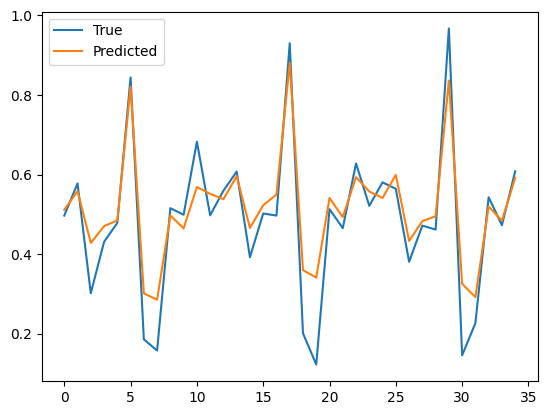

In [41]:
# generate predictions for the test set and calculate RMSE and plot the results
model.eval()
with torch.no_grad():
    # print(X_test.shape)
    y_pred = model(X_test)
    # print(y_pred.shape)
    y_pred = y_pred[:, -1, :]  # Take only the last time step output
    # print(y_pred.shape)
    test_rmse = np.sqrt(loss_fn(y_pred, y_test).item())
    print("Test RMSE %.4f" % test_rmse)
    plt.plot(y_test[:, 0].cpu().numpy(), label='True')
    plt.plot(y_pred[:, 0].cpu().numpy(), label='Predicted')
    plt.legend()
    plt.show()

Mean Absolute Error: 8326.0286


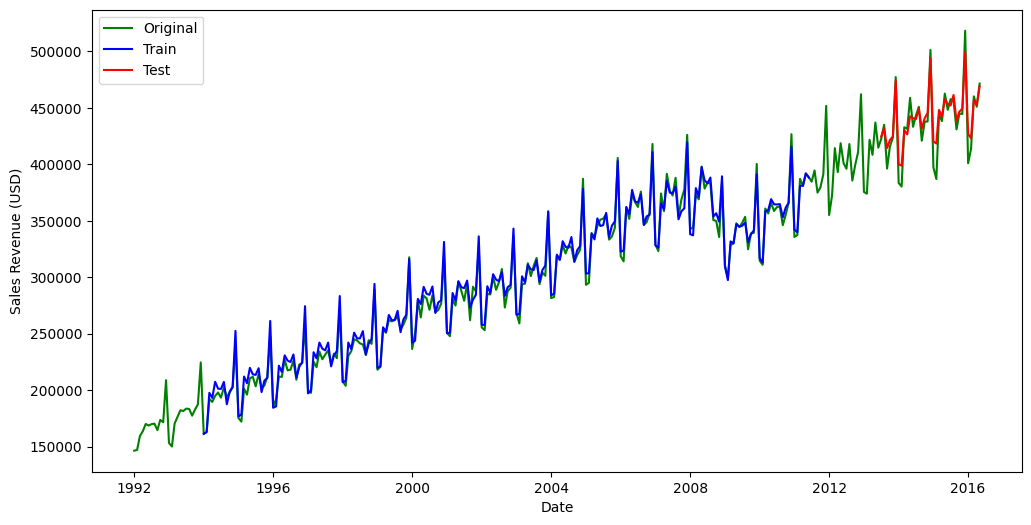

In [42]:
# Plot the predictions on the original scale 
with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred_train = model(X_train)
    # print(y_pred_train.shape)
    y_pred_train = y_pred_train[:, -1, :].squeeze()  # Take only the last time step output
    y_pred_train = y_pred_train.cpu().numpy()  # Move to CPU and convert to NumPy
    y_pred_train = scaler.inverse_transform(y_pred_train) # Inverse transform to original scale
    y_pred_train[:,0] += trend_train[lookback:] # Add trend back
    train_plot[lookback:train_size] = y_pred_train[:,0]
    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    y_pred_test = model(X_test)
    y_pred_test = y_pred_test[:, -1, :].squeeze()  # Take only the last time step output
    y_pred_test = y_pred_test.cpu().numpy()  # Move to CPU and convert to NumPy
    y_pred_test = scaler.inverse_transform(y_pred_test) # Inverse transform to original scale
    y_pred_test[:,0] +=  trend_test[lookback:] # Add trend back
    test_plot[train_size + lookback:] = y_pred_test[:,0]

# print the Mean Absolute Error
mae = np.mean(np.abs(y_pred_test[:,0] - test[lookback:]))
print("Mean Absolute Error: %.4f" % mae)
# Plot the results
plt.figure(figsize=(12, 6))
x = dt['date']
plt.plot(x, timeseries, color='green', label='Original')
plt.plot(x, train_plot, color='blue', label='Train')
plt.plot(x, test_plot, color='red', label='Test')
plt.ylabel("Sales Revenue (USD)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [43]:
print("Mean Absolute Error: %.4f" % mae)

Mean Absolute Error: 8326.0286
